## Basic installation and setup

### Installation

In [ ]:
!pip install ogb

In [ ]:
import torch

def format_pytorch_version(version):
  return version.split('+')[0]

TORCH_version = torch.__version__
TORCH = format_pytorch_version(TORCH_version)

def format_cuda_version(version):
  return 'cu' + version.replace('.', '')

CUDA_version = torch.version.cuda
CUDA = format_cuda_version(CUDA_version)

!pip install torch-scatter     -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-sparse      -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-cluster     -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-spline-conv -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-geometric

### Load and configure data

In [3]:
import torch
from ogb.linkproppred import PygLinkPropPredDataset

import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
from google.colab import files

from sklearn.preprocessing import MinMaxScaler

import networkx as nx
import numpy as np

In [ ]:

dataset = PygLinkPropPredDataset(name = 'ogbl-ddi') 

split_edge = dataset.get_edge_split()
train_edge, valid_edge, test_edge = split_edge["train"]["edge"], split_edge["valid"]["edge"], split_edge["test"]["edge"]
graph = dataset[0] # pyg graph object containing only training edges

### Extracting basics from graph

In [8]:
train_edges = dataset[0]["edge_index"]
edge_list = train_edges.transpose(0,1 ).tolist()
print(dataset[0])

Data(num_nodes=4267, edge_index=[2, 2135822])
torch.Size([2, 2135822])


tensor([[4039, 2424],
        [4039,  225],
        [4039, 3901],
        ...,
        [ 647,  708],
        [ 708,  338],
        [ 835, 3554]])

In [7]:
# Make graph and adjacency

G = nx.from_edgelist(edge_list)
G.number_of_nodes()
A = nx.to_numpy_matrix(G) # adjacency
L = nx.normalized_laplacian_matrix(G) # normalized laplacian. 

## Visualizing the graph

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

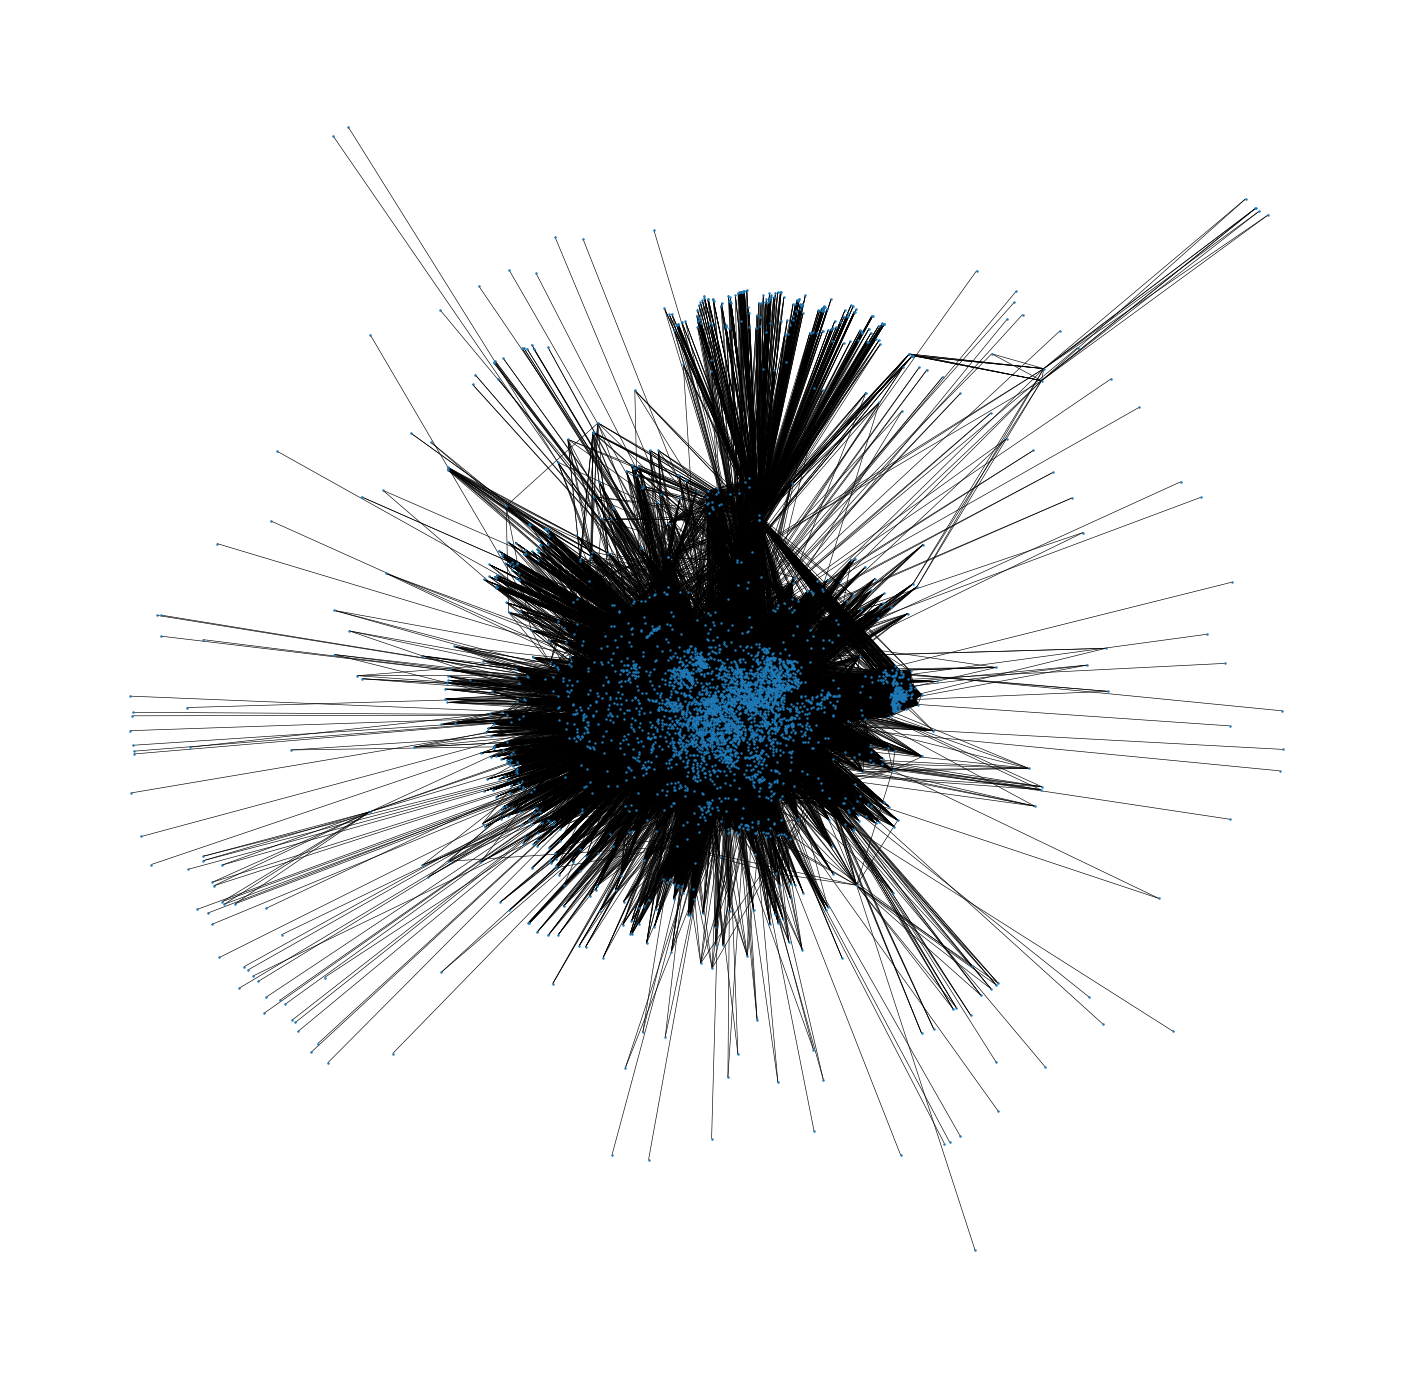

In [ ]:
plt.figure(figsize=(20, 20), dpi=90)
plt.axis('off')
fig = plt.figure(1)
pos = nx.spring_layout(G)
nx.draw_networkx_nodes(G, pos, node_size=0.95)
nx.draw_networkx_edges(G, pos, width=0.5)

plt.savefig('ogbddi_viz.pdf')

files.download('ogbddi_viz.pdf')

## Connectedness, diameter and eccentricity distribution

In [ ]:
print("Graph is connected: ", nx.is_connected(G))
print("Diameter of the graph: ", nx.diameter(G))

Graph is connected:  True
Diameter of the graph:  5


In [ ]:
ls = []
for v in G.nodes():
  ls.append(nx.eccentricity(G, v=v))

4267


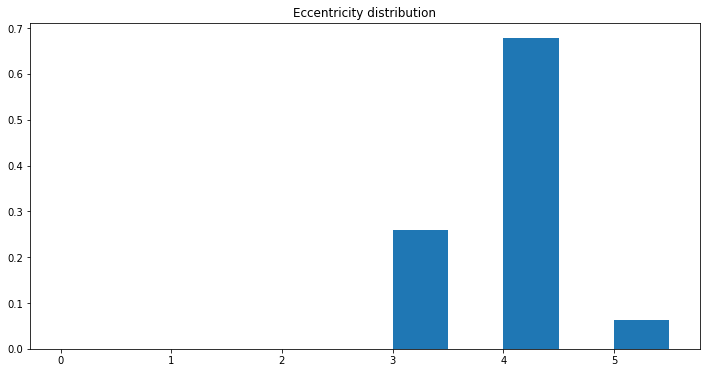

In [ ]:
# Eccentricity distribution

eccentricity = ls
eccentricity_norm = np.ones(len(eccentricity)) / len(eccentricity)
plt.figure(figsize=(12, 6))
plt.title('Eccentricity distribution')
i = plt.hist(eccentricity, weights=eccentricity_norm, bins=np.arange(0, np.max(eccentricity)+1, 0.5)); # can change granularity in last arg
plt.savefig("eccent_dist.pdf")

files.download('eccent_dist.pdf')

## Pairwise shortest path distances (Pairwise - SPD)

In [ ]:
# Calculate SPD between all nodes

spd = torch.zeros((len(G.nodes()), len(G.nodes())))
for i, v in enumerate(G.nodes()):
  for j, w in enumerate(G.nodes()):
    if i<j:
      spd[i, j] = nx.shortest_path_length(G, source=v, target=w)
for i, v in enumerate(G.nodes()):
  for j, w in enumerate(G.nodes()):
    if i>j:
      spd[i, j] = spd[j, i]
    if i==j:
      spd[i, j] = 0

4267


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

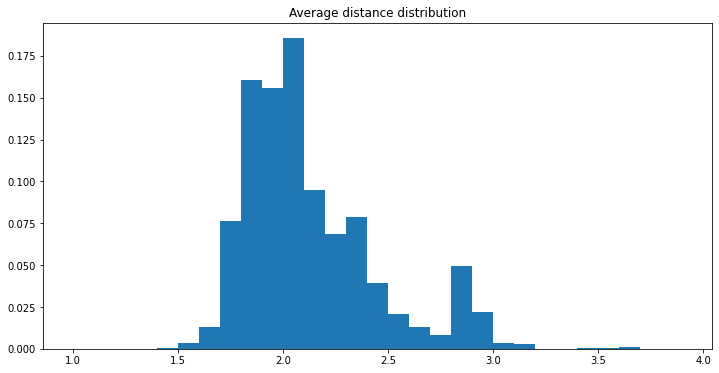

In [ ]:
# Visualize distribution of average distance to other nodes

avg_dist = np.mean(spd.detach().cpu().numpy(), axis=0)
avg_dist_norm = np.ones(len(avg_dist)) / len(avg_dist)
plt.figure(figsize=(12, 6))
plt.title('Average distance distribution')
i = plt.hist(avg_dist, weights=avg_dist_norm, bins=np.arange(1, 4, 0.1)); # can change granularity in last arg
plt.savefig("avg_dist_distribution.pdf")

files.download('avg_dist_distribution.pdf')

## Eigen features:

In [ ]:
# Get eigen-decomposition

L_dense = L.todense()
L_tens = torch.tensor(L_dense)
print("cuda game? ", torch.cuda.is_available())
L_cud = L_tens.to("cuda")
lamb, U = torch.linalg.eig(L_cud)
print(lamb.shape, U.shape)
lamb_real, U_real = torch.real(lamb), torch.real(U)

cuda game?  True
torch.Size([4267]) torch.Size([4267, 4267])


In [ ]:
lamb_real_sorted, indices = torch.sort(lamb_real)
U_sorted = U_real[indices]
U_sorted

tensor([[ 2.1267e-02,  5.9074e-03,  1.0047e-04,  ..., -2.1383e-14,
         -5.1169e-14, -4.2731e-14],
        [ 1.5498e-02,  3.9221e-03, -1.7715e-04,  ...,  1.3488e-13,
          1.8705e-13,  1.4791e-13],
        [ 2.3204e-02, -2.1355e-02,  3.1912e-04,  ...,  1.2813e-13,
          1.3433e-13,  1.5363e-13],
        ...,
        [ 1.6635e-02,  4.2423e-03, -1.4775e-05,  ...,  2.1729e-13,
          2.2451e-13,  2.2635e-13],
        [ 2.4700e-02,  1.3665e-03, -2.2038e-04,  ..., -1.4150e-14,
          8.0266e-14, -8.0960e-15],
        [ 1.8639e-02,  4.7886e-03,  3.0424e-04,  ..., -7.2871e-15,
         -2.5915e-14, -1.1358e-14]], device='cuda:0', dtype=torch.float64)

### Visualize eigenvalues

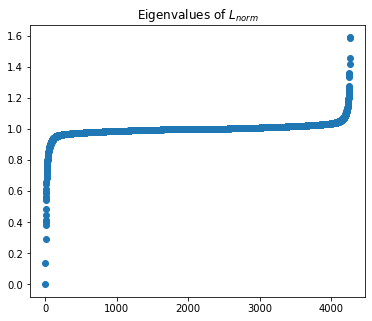

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# Eigenvalues plot

lam = lamb_real_sorted.cpu().numpy()
plt.figure(figsize=(6, 5))
plt.scatter(np.arange(len(lam[0:-1])), lam[0:-1])
plt.title('Eigenvalues of $L_{norm}$')
plt.savefig("N_eigenvals.pdf")
plt.show()
files.download('N_eigenvals.pdf')

### Distribution of eigenvalues

torch.Size([4267])


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

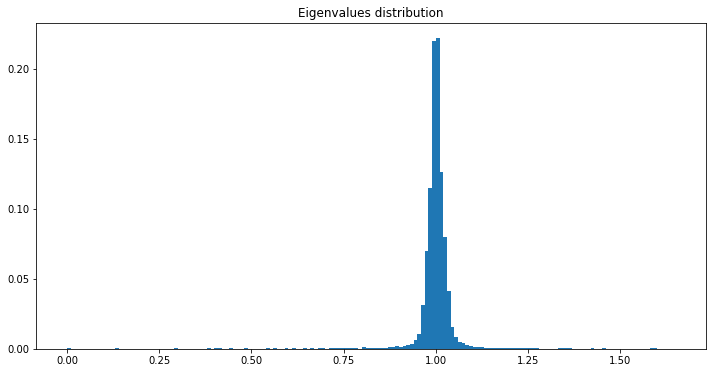

In [ ]:
# Eigen value distribution features

print(lamb_real_sorted.shape)
lamb_real = lamb_real_sorted.detach().cpu().numpy()
eig_norm = np.ones(lamb_real.shape[0]) / lamb_real.shape[0]
plt.figure(figsize=(12, 6))
plt.title('Eigenvalues distribution')
plt.hist(lamb_real, weights=eig_norm, bins=np.arange(0, lamb_real.max(), 0.01)); # can change granularity in last arg
plt.savefig("eig_dist.pdf")
files.download('eig_dist.pdf')

### Plotting eigenvectors

In [ ]:
# Min-max scale first

scaler = MinMaxScaler()
scaler.fit(U_sorted.cpu())

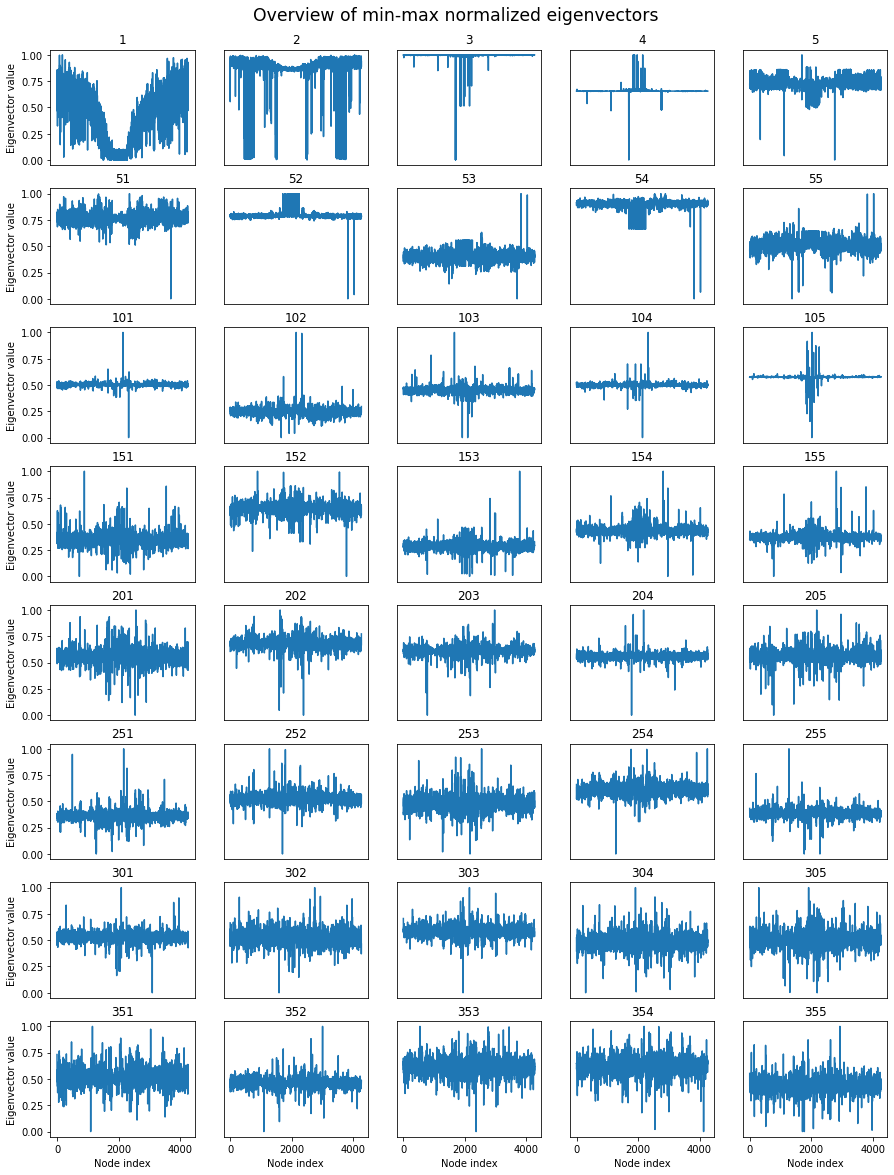

In [ ]:
fig, ax = plt.subplots(8,5,figsize=(15, 20))

U_sorted_minmax = scaler.transform(U_sorted.cpu())

windowsize = 50
fig.suptitle("Overview of min-max normalized eigenvectors", y = 0.91, fontsize="xx-large")
for i in range(8):
  for j in range(5):
    ax[i,j].plot(U_sorted_minmax[:,windowsize*i + j])

    if i < 7:
      ax[i, j].tick_params(labelbottom = False, bottom = False)
    else:
      ax[i,j].set_xlabel("Node index")
    if j > 0:
      ax[i, j].tick_params(left = False, labelleft = False)
    else:
      ax[i, j].set_ylabel("Eigenvector value")

    ax[i, j].set_title(windowsize*i + j + 1)
plt.savefig("eigenvectors.png")
#plt.subplots_adjust(wspace=0, hspace=0)

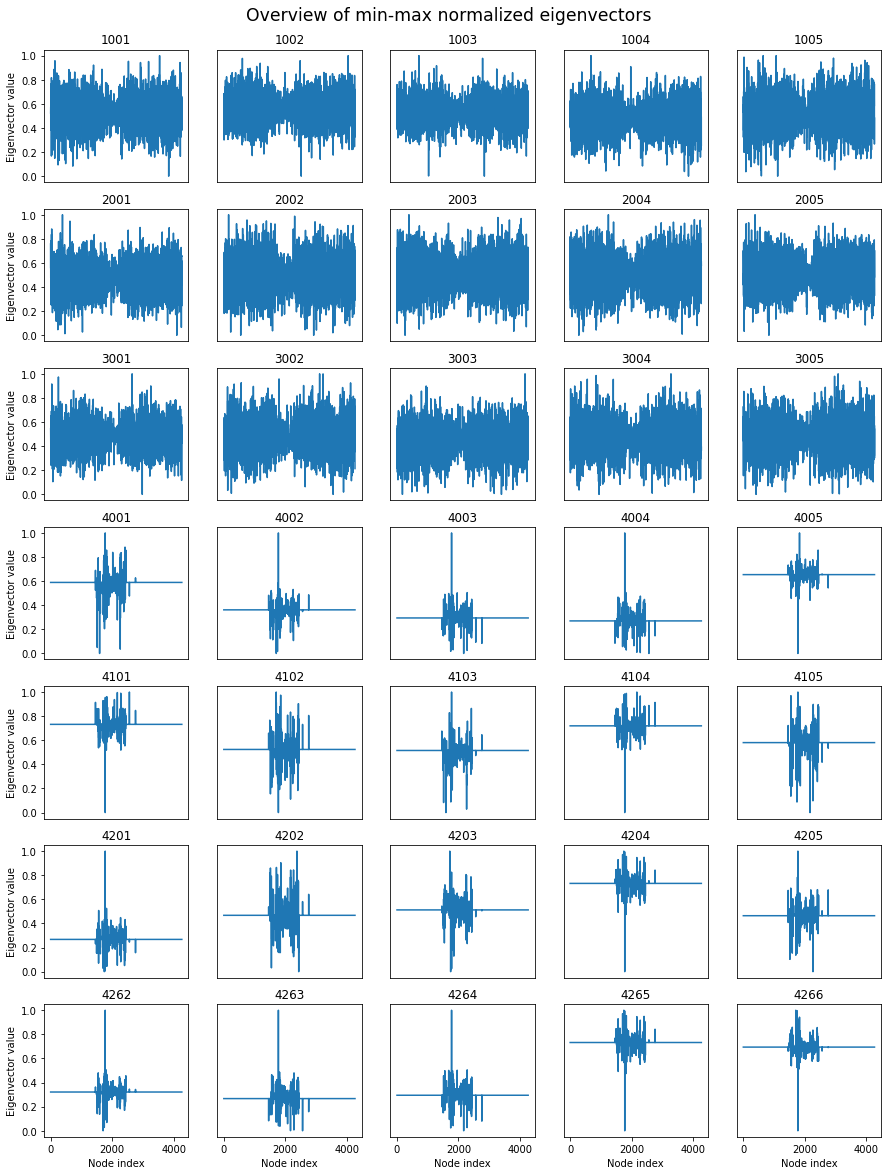

In [ ]:
fig, ax = plt.subplots(7,5,figsize=(15, 20))

U_sorted_minmax = scaler.transform(U_sorted.cpu())

windowsize = 1000
fig.suptitle("Overview of min-max normalized eigenvectors", y = 0.91, fontsize="xx-large")
for i in range(4):
  for j in range(5):
    ax[i,j].plot(U_sorted_minmax[:,windowsize*(i+1) + j])

    if i < 7:
      ax[i, j].tick_params(labelbottom = False, bottom = False)
    else:
      ax[i,j].set_xlabel("Node index")
    if j > 0:
      ax[i, j].tick_params(left = False, labelleft = False)
    else:
      ax[i, j].set_ylabel("Eigenvector value")

    ax[i, j].set_title(windowsize*(i+1) + j + 1)

for i in range(2):
  for j in range(5):
    ax[i+4,j].plot(U_sorted_minmax[:,4000 + 100*(i+1) + j])

    if i < 7:
      ax[i + 4, j].tick_params(labelbottom = False, bottom = False)
    else:
      ax[i + 4,j].set_xlabel("Node index")
    if j > 0:
      ax[i + 4, j].tick_params(left = False, labelleft = False)
    else:
      ax[i + 4, j].set_ylabel("Eigenvector value")

    ax[i + 4, j].set_title(4000 + 100*(i+1) + j + 1)

for j in range(5):
  ax[6,j].plot(U_sorted_minmax[:,4000 + 262 + j])

  ax[6,j].set_xlabel("Node index")
  if j > 0:
    ax[6, j].tick_params(left = False, labelleft = False)
  else:
    ax[6, j].set_ylabel("Eigenvector value")

  ax[6, j].set_title(4000 + 262 + j)
plt.savefig("eigenvectors_higher_index.png")


## Degree distribution

(4267,)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

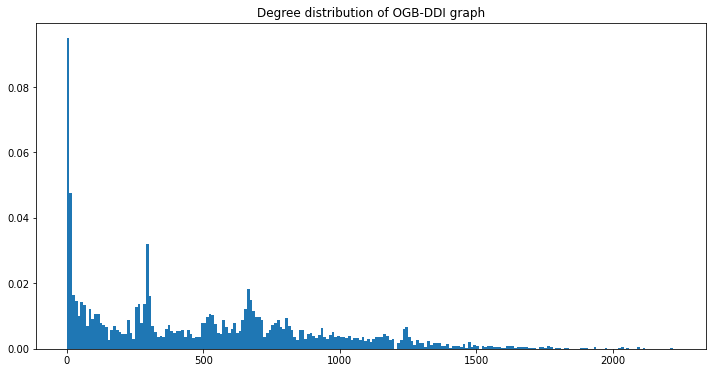

In [ ]:
# DEGREE features

degree_features = np.array(np.sum(A, axis=0))[0]
deg_hist_normalization = np.ones(degree_features.shape[0]) / degree_features.shape[0]
plt.figure(figsize=(12, 6))
plt.title('Degree distribution of OGB-DDI graph')
plt.hist(degree_features, weights=deg_hist_normalization, bins=range(0, int(degree_features.max()), 10))
plt.savefig("degree_dist.pdf")
files.download('degree_dist.pdf')

### Smoothness of degree distribution

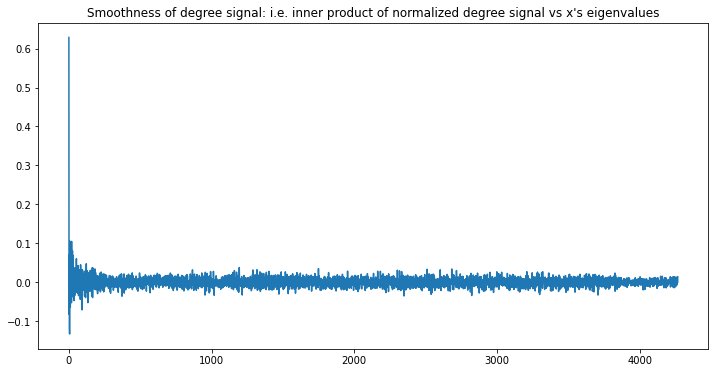

In [ ]:
# How smooth is the degree distribution?

normalized_deg = degree_features/np.linalg.norm(degree_features) # normalize feature degrees
smoothness = U_sorted.detach().cpu().numpy().transpose()@normalized_deg
plt.figure(figsize=(12, 6))
plt.title("Smoothness of degree signal: i.e. inner product of normalized degree signal vs x's eigenvalues")
plt.plot(smoothness)
